In [12]:
#import tensorflowjs as tfjs
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Reshape, UpSampling2D, BatchNormalization, AveragePooling2D, Activation, Lambda
from keras.models import Model, Sequential
#from keras import backend as K
#import tensorflow as tf

in_height = 360
in_width =  640

out_height = 720
out_width = 1280

#tf.compat.v1.disable_eager_execution()

In [13]:
encoder_input =  Input(shape=(in_height,in_width,3))

# Encoder Layers
#autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
encoder = Conv2D(16, (3, 3), activation='relu' ,padding='same')(encoder_input)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = AveragePooling2D((2, 2), padding='same')(encoder)
encoder =  Flatten(name='flatten_1')(encoder)
encoder_model = Model(encoder_input,encoder)
encoder_model.summary()
encoder_model.load_weights("8-encoder.h5")
#

# Decoder Layers
decoder_input = Input(shape=(115200,))
#decoder = Dense(38400,activation="relu",name='decoder_input')(decoder_input)
decoder = Reshape(( 90, 160, 8))(decoder_input)
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
decoder =  UpSampling2D((2, 2),interpolation='bilinear')(decoder)
decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2),interpolation='bilinear')(decoder)
decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2),interpolation='bilinear')(decoder)
decoder = Conv2D(8, (3, 3), padding='same',activation='relu')(decoder)
decoder = Conv2D(3, (3, 3), padding='same',activation='relu')(decoder)


decoder_model = Model(decoder_input,decoder)
decoder_model.summary()
decoder_model.load_weights("8-decoder.h5")

autoencoder = Model(encoder_input,decoder_model(encoder))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 360, 640, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 360, 640, 16)      448       
_________________________________________________________________
average_pooling2d_7 (Average (None, 180, 320, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 180, 320, 8)       1160      
_________________________________________________________________
average_pooling2d_8 (Average (None, 90, 160, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________
________

In [ ]:
tfjs.converters.save_keras_model(autoencoder, './tensorflowjs-model/')

In [15]:
import cv2, os
import numpy as np

dir_ = "./../flickr30k_images/"
X = list()
Y = list()
files = os.listdir(dir_)

def getImage(file):
    #‪C:\Users\mayan\Downloads\2-dog.jpg
    frame = cv2.imread(file,1)
    return [np.array([cv2.resize(frame,(in_width,in_height))]),np.array([cv2.resize(frame,(out_width,out_height))])]

def getData(batch_size=128):
    while True:
        for i , file in enumerate(files):
            frame = cv2.imread(dir_ + file,1)
            try:
                Y.append(cv2.resize(frame,(out_width,out_height)))
                X.append(cv2.resize(frame,(in_width,in_height)))
                if (i + 1) % batch_size == 0:
                        yield (np.array(X),np.array(Y))
                        X.clear()
                        Y.clear()
            except Exception as ex:
                print(ex)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
from keras.optimizers import Adam, Adadelta

#datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,horizontal_flip=True,vertical_flip=True)
# fit parameters from data
#datagen.fit(frames)
# configure batch size and retrieve one batch of images

#autoencoder.compile(optimizer='adam', loss=vae_loss)
#for X_, Y_ in datagen.flow(X,Y, batch_size=256):
#autoencoder.fit_generator(getData(8),epochs=10,samples_per_epoch=50)
autoencoder.compile(optimizer='adam', loss='mean_absolute_error',metrics=['acc'])

for X_, Y_ in getData(256):
    #for X_D,Y_D in datagen.flow(X_,Y_,batch_size=128): 
    autoencoder.fit(X_, Y_,
                epochs=10,
                batch_size=8,validation_split=0.2)
    clear_output()

    json= decoder_model.to_json()
    with open("8-decoder.json", "w") as json_file:
        json_file.write(json)

    decoder_model.save_weights("8-decoder.h5")

    json= encoder_model.to_json()
    with open("8-encoder.json", "w") as json_file:
        json_file.write(json)
    encoder_model.save_weights("8-encoder.h5")

    print("Saved model to disk")


Saved model to disk
Train on 204 samples, validate on 52 samples
Epoch 1/10
204/204 [==============================] - 15s 72ms/step - loss: 6.5903 - acc: 0.8402 - val_loss: 7.1558 - val_acc: 0.8298
Epoch 2/10
204/204 [==============================] - 15s 73ms/step - loss: 6.8047 - acc: 0.8488 - val_loss: 7.6046 - val_acc: 0.8518
Epoch 3/10
204/204 [==============================] - 15s 72ms/step - loss: 6.7567 - acc: 0.8400 - val_loss: 7.1265 - val_acc: 0.8356
Epoch 4/10
204/204 [==============================] - 15s 73ms/step - loss: 6.5805 - acc: 0.8527 - val_loss: 7.1699 - val_acc: 0.8291
Epoch 5/10
204/204 [==============================] - 15s 74ms/step - loss: 6.4965 - acc: 0.8480 - val_loss: 7.3113 - val_acc: 0.8050
Epoch 6/10
204/204 [==============================] - 15s 75ms/step - loss: 6.5845 - acc: 0.8444 - val_loss: 7.8754 - val_acc: 0.7968
Epoch 7/10
204/204 [==============================] - 15s 73ms/step - loss: 6.4844 - acc: 0.8399 - val_loss: 7.1558 - val_acc: 0.82

In [ ]:
##Save Model
json= decoder_model.to_json()
with open("decoder.json", "w") as json_file:
    json_file.write(json)

decoder_model.save_weights("decoder.h5")

json= encoder_model.to_json()
with open("encoder.json", "w") as json_file:
    json_file.write(json)
encoder_model.save_weights("encoder.h5")

print("Saved model to disk")

In [15]:
import matplotlib.pyplot as plt
import imutils, time

%matplotlib inline

num_images = 10
np.random.seed(42)

#x_test,y_test = next(getData(16))
x_test,y_test = getImage('C:/Users/mayan/Downloads/2-dog.jpg')


W0913 22:41:06.890349  5304 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0913 22:41:08.006145  5304 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0913 22:41:08.228016  5304 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0913 22:41:08.427901  5304 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0913 22:41:08.620790  5304 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0913 22:41:08.820677  5304 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0913 22:41:09.019562  5304 image.py:693] Clipping input data to the valid range for ims

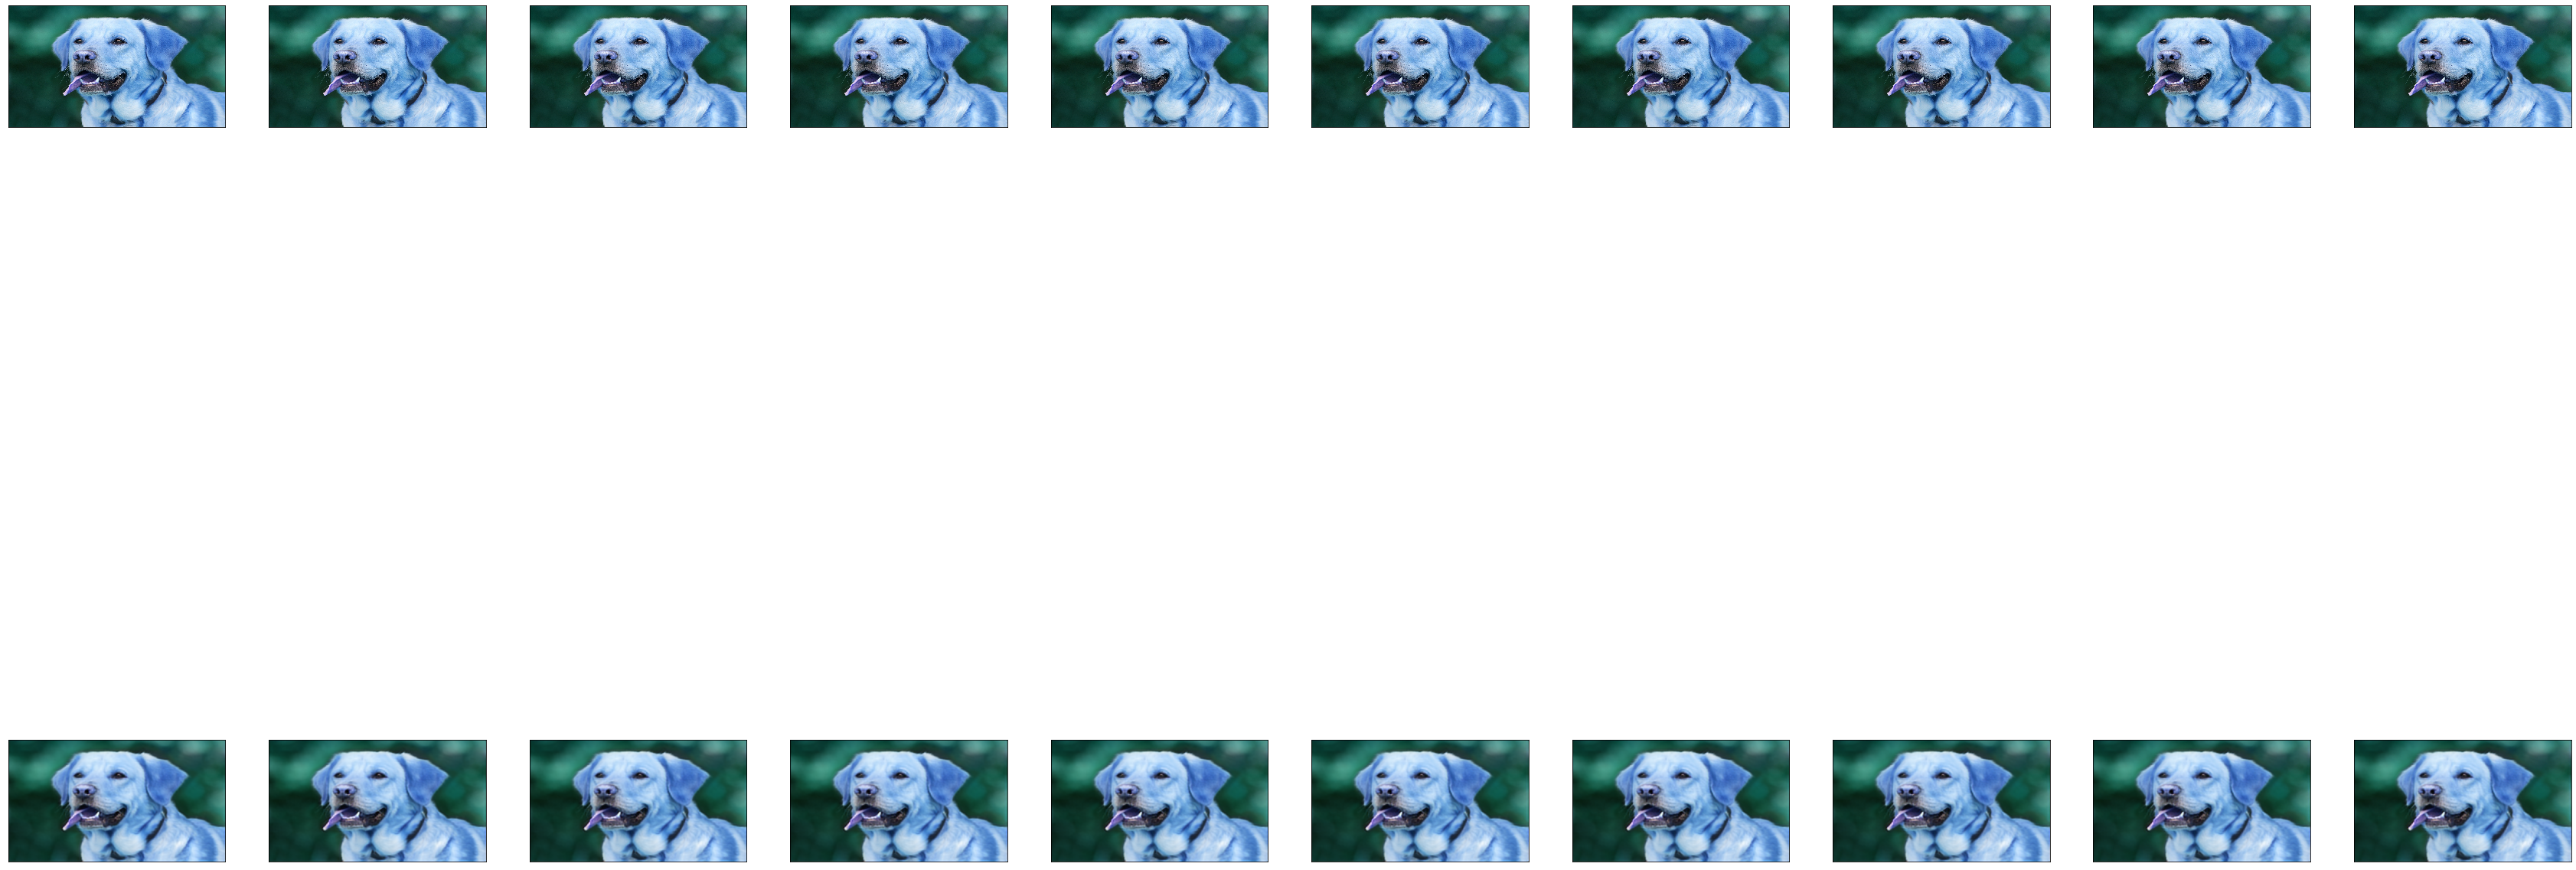

In [16]:
random_test_images = np.random.randint(y_test.shape[0], size=min(num_images,y_test.size))

encoded_imgs = encoder_model.predict(x_test)
decoded_imgs = decoder_model.predict(encoded_imgs)


plt.figure(figsize=(60, 50))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(y_test[image_idx])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cv2.imwrite("./real/%s.jpg" %time.time(),y_test[image_idx])
    '''
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(32, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    '''
    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    name = time.time()
    cv2.imwrite("./restructured/%s.jpg" %name,decoded_imgs[image_idx] )
    cv2.imwrite("./restructured/original-%s.jpg" %name,y_test[image_idx] )
    plt.imshow(decoded_imgs[image_idx]/255)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()